Data Source: [Coronavirus tweets data](https://www.kaggle.com/datatattle/covid-19-nlp-text-classification) (sentiment analysis).

### 0. Packages and general settings

In [1]:
# General purpose
import pandas as pd
import numpy as np
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Data preprocessing
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

# LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import time
# import random

In [2]:
# DistillBert
#import transformers
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification

In [3]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.despine()
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlepad=10)

<Figure size 432x288 with 0 Axes>

General Settings

In [4]:
RANDOM_SEED = 123456
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 10000
LEARNING_RATE = 0.002
BATCH_SIZE_RNN = 32
BATCH_SIZE_BERT = 16 # due to the memory limit
NUM_EPOCHS_RNN = 10
NUM_EPOCHS_BERT = 5
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 5

In [5]:
print(DEVICE)
print(torch.__version__)

cuda:0
1.10.1+cu113


### 1. Load Data & Preprocessing

In [6]:
df_tr = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')
df_te = pd.read_csv('Corona_NLP_test.csv', encoding='latin-1')
print('Shape of the training set:', df_tr.shape, '\nShape of the test set:', df_te.shape)

Shape of the training set: (41157, 6) 
Shape of the test set: (3798, 6)


In [7]:
df_tr.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive


In [8]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [9]:
# nltk.download()
stopwords = nltk.corpus.stopwords.words('english')

def senti_to_int(x):
    if x == 'Extremely Negative':
        return 0
    if x == 'Negative':
        return 1
    if x == 'Neutral':
        return 2
    if x == 'Positive':
        return 3
    else:
        return 4

df_tr['Sentiment'] = df_tr['Sentiment'].apply(lambda x: senti_to_int(x))
df_te['Sentiment'] = df_te['Sentiment'].apply(lambda x: senti_to_int(x))
#df_tr['Sentiment'] = df_tr['Sentiment'].map({'Extremely Negative':0,'Negative':1,
#                                    'Neutral':2,'Positive':3,'Extremely Positive':4})
#df_te['Sentiment'] = df_te['Sentiment'].map({'Extremely Negative':0,'Negative':1,
#                                    'Neutral':2,'Positive':3,'Extremely Positive':4})

In [10]:
def preprocess(df, text, keyword):
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    processed_text = []
    #stopWords = stopwords.words("english")
    for tweet, keyword in zip(df[text], df[keyword]):
        tweet_clean = []
        # remove hyperlinks
        tweet = re.sub(r'http\S+', '', tweet)
        # remove hashtags and mentions
        tweet = re.sub(r'\.{3}|@|#', '', tweet)
        # remove none alphanumeric and aposthrope
        tweet = "".join(re.sub("([^0-9A-Za-z \t'])"," ", tweet))
        # remove junk characters which don't have an ascii code
        tweet = tweet.encode("ascii", "ignore").decode("utf-8", "ignore")
        # remove emojis
        tweet = "".join(c for c in tweet if c not in emoji.UNICODE_EMOJI)
        # tokenize tweets
        tweet_tokens = tokenizer.tokenize(tweet)
        for word in tweet_tokens:
            tweet_clean.append(word)
        processed_text.append(" ".join(tweet_clean))
    df['CleanTweet'] = np.array(processed_text)

In [11]:
preprocess(df_tr, 'OriginalTweet','ScreenName')
preprocess(df_te, 'OriginalTweet','ScreenName')

In [12]:
df_tr.head(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,CleanTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2,menyrbie phil gahan chrisitv and and
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,3,advice talk to your neighbours family to excha...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,3,coronavirus australia woolworths to give elder...


Plot the distribution of the five classes

In [13]:
# Bar plot
def plotBar(df, feature, title):
    plt.figure(figsize=(7,4))
    ax = sns.countplot(x=feature, data=df, palette='mako')
    plt.title(title)
    plt.yticks([])
    ax.bar_label(ax.containers[0])
    plt.ylabel('count')
    plt.xlabel('')
    plt.show()

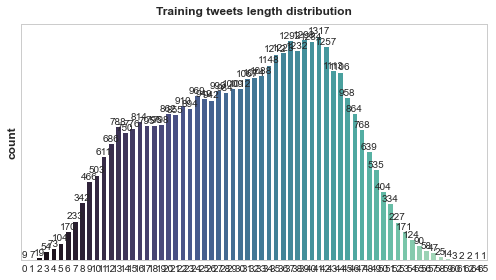

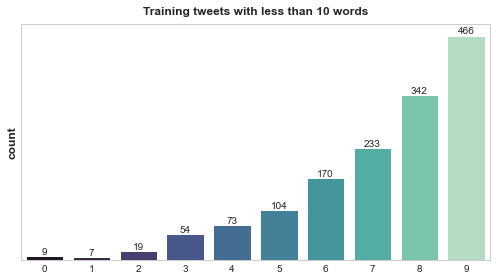

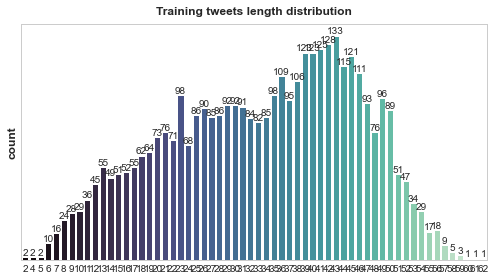

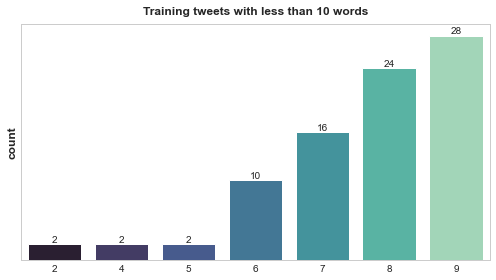

In [14]:
# length of the processed tweet
df_tr["CleanTweet_len"] = df_tr["CleanTweet"].apply(lambda row: len(row.split()))
df_te["CleanTweet_len"] = df_te["CleanTweet"].apply(lambda row: len(row.split()))
plotBar(df_tr, 'CleanTweet_len', 'Training tweets length distribution')
plotBar(df_tr[df_tr['CleanTweet_len']<10], 'CleanTweet_len', 'Training tweets with less than 10 words')

plotBar(df_te, 'CleanTweet_len', 'Training tweets length distribution')
plotBar(df_te[df_te['CleanTweet_len']<10], 'CleanTweet_len', 'Training tweets with less than 10 words')

In [15]:
# Drop the tweets that has less than or equal to 2 words
df_tr = df_tr[df_tr['CleanTweet_len'] > 2]
df_te = df_te[df_te['CleanTweet_len'] > 2]

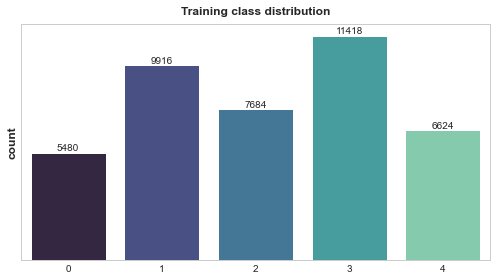

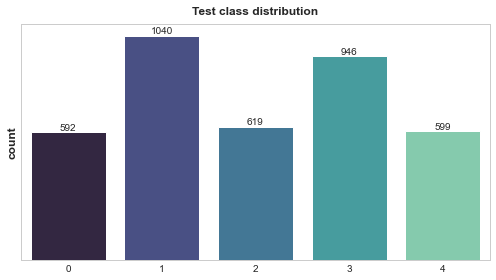

In [16]:
plotBar(df_tr, 'Sentiment', 'Training class distribution')
plotBar(df_te, 'Sentiment', 'Test class distribution')

From the above two plots we can see that both the training set and the test set are not too imbalanced.

In [17]:
# Train / validation split
data_tr_val = df_tr[['CleanTweet', 'Sentiment']]
data_tr_val = data_tr_val.sample(frac=1) # random shuffling
data_tr = data_tr_val.iloc[:math.ceil(df_tr.shape[0] * 0.9)]
data_val = data_tr_val.iloc[math.ceil(df_tr.shape[0] * 0.9):]
print(data_tr.shape, data_val.shape)

data_te = df_te[['CleanTweet', 'Sentiment']]
print(data_te.shape)

(37010, 2) (4112, 2)
(3796, 2)


In [18]:
data_tr.to_csv('train_data.csv', index=None)
data_val.to_csv('val_data.csv', index=None)
data_te.to_csv('test_data.csv', index=None)

In [19]:
del df_tr, df_te, data_tr_val

### 2. RNN, LSTM, and Bidirectional LSTM
Prepare dataloaders

In [20]:
TEXT = torchtext.legacy.data.Field(
    tokenize='spacy',
    tokenizer_language='en_core_web_sm',
)
LABEL = torchtext.legacy.data.LabelField(dtype=torch.long)

In [21]:
fields = [('CleanTweet', TEXT), ('Sentiment', LABEL)]

train_data = torchtext.legacy.data.TabularDataset(
    path='train_data.csv', format='csv',
    skip_header=True, fields=fields)

valid_data = torchtext.legacy.data.TabularDataset(
    path='val_data.csv', format='csv',
    skip_header=True, fields=fields)

test_data = torchtext.legacy.data.TabularDataset(
    path='test_data.csv', format='csv',
    skip_header=True, fields=fields)

In [22]:
TEXT.build_vocab(train_data, max_size=VOCABULARY_SIZE)
LABEL.build_vocab(train_data)

#print(f'Vocabulary size: {len(TEXT.vocab)}')
#print(f'Number of classes: {len(LABEL.vocab)}')

In [23]:
train_loader, valid_loader, test_loader = \
    torchtext.legacy.data.BucketIterator.splits(
        (train_data, valid_data, test_data),
        batch_size=BATCH_SIZE_RNN,
        #sort_within_batch=True,
        sort_key=lambda x: len(x.CleanTweet),
        sort=False,
        shuffle=False,
        device=DEVICE
    )

Utility functions

In [24]:
def get_accuracy1(model, data_loader, device):
    
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for _, (features, targets) in enumerate(data_loader):
            features = features.to(device)
            targets = targets.to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    
    return correct_pred.float() / num_examples * 100

In [25]:
def train(model, NUM_EPOCHS, train_loader, valid_loader, test_loader):
    start_time = time.time()

    for epoch in range(NUM_EPOCHS):
        model.train()
        
        for batch_idx, batch_data in enumerate(train_loader):
            text = batch_data.CleanTweet.to(DEVICE)
            labels = batch_data.Sentiment.to(DEVICE)

            # forward
            logits = model(text)
            loss = F.cross_entropy(logits, labels)
            optimizer.zero_grad()

            # back propogation
            loss.backward()

            # update parameters
            optimizer.step()
        
        with torch.set_grad_enabled(False):
            print(
                f'Epoch: {epoch}\n'
                f'training accuracy: '
                f'{get_accuracy1(model, train_loader, DEVICE):.2f}%'
                f'\nvalid accuracy: '
                f'{get_accuracy1(model, valid_loader, DEVICE):.2f}%'
            )

        print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')

    print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
    print(f'Test accuracy: {get_accuracy1(model, test_loader, DEVICE):.2f}%')

In [26]:
# Prediction
def prediction(model, test_loader):
    test_pred = []

    with torch.no_grad():       
        for _, (features, targets) in enumerate(test_loader):
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            test_pred.extend(predicted_labels.cpu().detach().numpy().tolist())

    return test_pred

In [27]:
# Plot the confusion matrix and print out evaluation metrics
def eval_metrics(y_test, y_pred):
    labels = ['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive']
    cf_matrix = confusion_matrix(y_test, y_pred)
    cf_matrix = pd.DataFrame(cf_matrix, index = labels, columns = labels)
    plt.figure(figsize = (10,7))
    sns.heatmap(cf_matrix, annot=True, cmap="Blues")
    report = classification_report(y_pred, y_test)
    print(report)

#### 2.1 RNN

In [28]:
class tweetRNN(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, num_classes):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, embed_dim)  
        self.rnn = nn.RNN(embed_dim, hidden_dim, nonlinearity='relu')
                
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    
    def forward(self, text):

        # text dim: [sentence length, batch size]
        text_embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]

        out, hidden = self.rnn(text_embedded)
        # out dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]
        
        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]
        hidden = self.dropout(hidden)
        out = self.fc1(hidden)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [29]:
torch.manual_seed(RANDOM_SEED)

model_rnn = tweetRNN(input_dim=len(TEXT.vocab), embed_dim=EMBEDDING_DIM,
                     hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
model_rnn = model_rnn.to(DEVICE)
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=LEARNING_RATE)

In [30]:
train(model_rnn, NUM_EPOCHS_RNN, train_loader, valid_loader, test_loader)

Epoch: 0
training accuracy: 27.75%
valid accuracy: 27.77%
Time elapsed: 0.15 min
Epoch: 1
training accuracy: 27.83%
valid accuracy: 27.85%
Time elapsed: 0.30 min
Epoch: 2
training accuracy: 27.97%
valid accuracy: 27.82%
Time elapsed: 0.45 min
Epoch: 3
training accuracy: 27.94%
valid accuracy: 27.75%
Time elapsed: 0.59 min
Epoch: 4
training accuracy: 28.16%
valid accuracy: 27.99%
Time elapsed: 0.74 min
Epoch: 5
training accuracy: 28.15%
valid accuracy: 28.14%
Time elapsed: 0.89 min
Epoch: 6
training accuracy: 28.17%
valid accuracy: 28.14%
Time elapsed: 1.02 min
Epoch: 7
training accuracy: 28.15%
valid accuracy: 27.80%
Time elapsed: 1.15 min
Epoch: 8
training accuracy: 28.16%
valid accuracy: 27.75%
Time elapsed: 1.28 min
Epoch: 9
training accuracy: 28.21%
valid accuracy: 27.97%
Time elapsed: 1.40 min
Total Training Time: 1.40 min
Test accuracy: 24.79%


In [31]:
# Save and load the trained model
torch.save(model_rnn.state_dict(), 'saved_data/model_rnn.pt')
torch.save(optimizer.state_dict(), 'saved_data/optimizer_rnn.pt')

#model_rnn.load_state_dict(torch.load('saved_data/model_rnn.pt'))
#optimizer.load_state_dict(torch.load('saved_data/optimizer_rnn.pt'))

              precision    recall  f1-score   support

           0       0.97      0.15      0.27      3723
           1       0.01      0.33      0.02        39
           2       0.00      0.00      0.00         0
           3       0.00      0.29      0.01        14
           4       0.00      0.05      0.00        20

    accuracy                           0.16      3796
   macro avg       0.20      0.16      0.06      3796
weighted avg       0.95      0.16      0.26      3796



C:\Users\ljg08\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ljg08\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ljg08\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

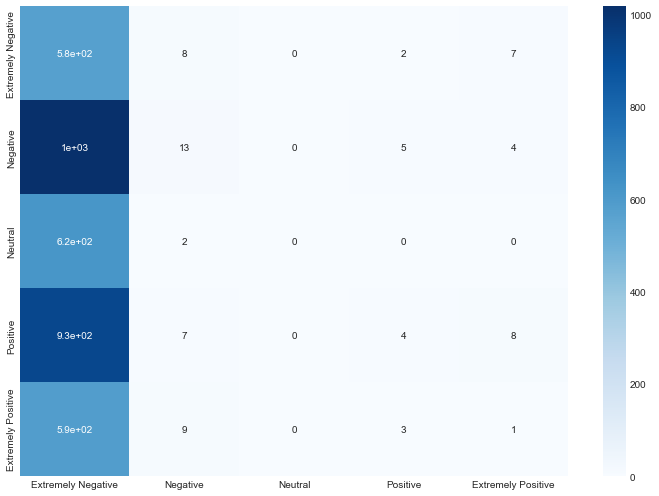

In [32]:
y_test = data_te['Sentiment'].tolist()
y_pred = prediction(model_rnn, test_loader) 
eval_metrics(y_test, y_pred)

#### 2.2 LSTM

In [33]:
class tweetLSTM(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, num_classes):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    
    def forward(self, text):

        # text dim: [sentence length, batch size]
        text_embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]

        out, (hidden, cell) = self.rnn(text_embedded)
        # out dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]
        
        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]
        hidden = self.dropout(hidden)
        out = self.fc1(hidden)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [34]:
torch.manual_seed(RANDOM_SEED)

model_lstm = tweetLSTM(input_dim=len(TEXT.vocab), embed_dim=EMBEDDING_DIM,
                       hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
model_lstm = model_lstm.to(DEVICE)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=LEARNING_RATE)

In [35]:
train(model_lstm, NUM_EPOCHS_RNN, train_loader, valid_loader, test_loader)

Epoch: 0
training accuracy: 37.71%
valid accuracy: 36.77%
Time elapsed: 0.18 min
Epoch: 1
training accuracy: 68.16%
valid accuracy: 64.57%
Time elapsed: 0.35 min
Epoch: 2
training accuracy: 79.80%
valid accuracy: 72.59%
Time elapsed: 0.53 min
Epoch: 3
training accuracy: 84.74%
valid accuracy: 73.39%
Time elapsed: 0.71 min
Epoch: 4
training accuracy: 87.65%
valid accuracy: 73.71%
Time elapsed: 0.88 min
Epoch: 5
training accuracy: 91.06%
valid accuracy: 75.51%
Time elapsed: 1.06 min
Epoch: 6
training accuracy: 92.12%
valid accuracy: 74.25%
Time elapsed: 1.23 min
Epoch: 7
training accuracy: 92.49%
valid accuracy: 74.32%
Time elapsed: 1.41 min
Epoch: 8
training accuracy: 93.55%
valid accuracy: 75.05%
Time elapsed: 1.59 min
Epoch: 9
training accuracy: 94.52%
valid accuracy: 74.71%
Time elapsed: 1.76 min
Total Training Time: 1.76 min
Test accuracy: 72.52%


In [36]:
# Save and load the trained model
torch.save(model_lstm.state_dict(), 'saved_data/model_lstm.pt')
torch.save(optimizer.state_dict(), 'saved_data/optimizer_lstm.pt')

#model_lstm.load_state_dict(torch.load('saved_data/model_lstm.pt'))
#optimizer.load_state_dict(torch.load('saved_data/optimizer_lstm.pt'))

              precision    recall  f1-score   support

           0       0.01      0.01      0.01       935
           1       0.73      0.66      0.69      1158
           2       0.78      0.77      0.78       626
           3       0.09      0.16      0.11       523
           4       0.00      0.00      0.00       554

    accuracy                           0.35      3796
   macro avg       0.32      0.32      0.32      3796
weighted avg       0.37      0.35      0.36      3796



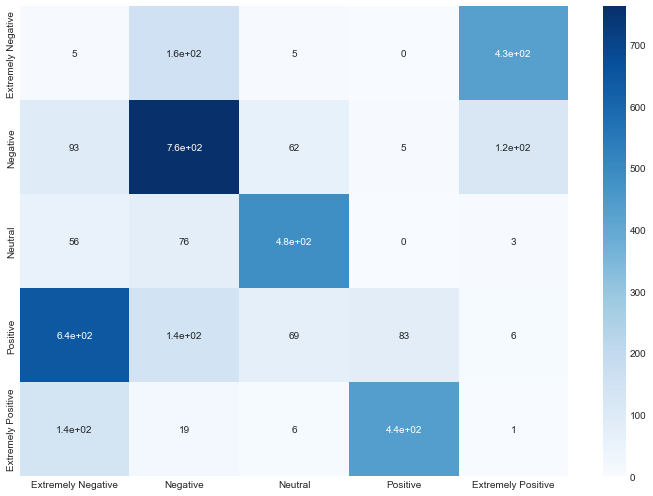

In [37]:
y_test = data_te['Sentiment'].tolist()
y_pred = prediction(model_lstm, test_loader) 
eval_metrics(y_test, y_pred)

#### 2.3 Bidrectional LSTM

In [38]:
class tweetBiLSTM(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, num_classes):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, bidirectional=True)
        
        self.fc1 = nn.Linear(2*hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    
    def forward(self, text):

        # text dim: [sentence length, batch size]
        text_embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]

        # out, hidden = self.rnn(text_embedded)
        out, (hidden, cell) = self.rnn(text_embedded)
        # out dim: [sentence length, batch size, 2*hidden dim]
        # hidden dim: [2, batch size, hidden dim]
        
        hidden = torch.cat([hidden[0,:,:], hidden[1,:,:]],dim=1).squeeze_(0)
        # hidden dim: [batch size, hidden dim]
        hidden = self.dropout(hidden)
        out = self.fc1(hidden)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [39]:
torch.manual_seed(RANDOM_SEED)

model_bilstm = tweetBiLSTM(input_dim=len(TEXT.vocab), embed_dim=EMBEDDING_DIM,
                           hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
model_bilstm = model_bilstm.to(DEVICE)
optimizer = torch.optim.Adam(model_bilstm.parameters(), lr=LEARNING_RATE)

In [40]:
train(model_bilstm, NUM_EPOCHS_RNN, train_loader, valid_loader, test_loader)

Epoch: 0
training accuracy: 63.35%
valid accuracy: 58.85%
Time elapsed: 0.25 min
Epoch: 1
training accuracy: 77.28%
valid accuracy: 70.77%
Time elapsed: 0.50 min
Epoch: 2
training accuracy: 83.76%
valid accuracy: 75.39%
Time elapsed: 0.75 min
Epoch: 3
training accuracy: 87.27%
valid accuracy: 76.00%
Time elapsed: 1.00 min
Epoch: 4
training accuracy: 89.56%
valid accuracy: 76.85%
Time elapsed: 1.25 min
Epoch: 5
training accuracy: 92.05%
valid accuracy: 76.65%
Time elapsed: 1.51 min
Epoch: 6
training accuracy: 92.67%
valid accuracy: 76.12%
Time elapsed: 1.76 min
Epoch: 7
training accuracy: 93.02%
valid accuracy: 75.83%
Time elapsed: 2.01 min
Epoch: 8
training accuracy: 94.28%
valid accuracy: 77.14%
Time elapsed: 2.26 min
Epoch: 9
training accuracy: 95.07%
valid accuracy: 76.31%
Time elapsed: 2.51 min
Total Training Time: 2.51 min
Test accuracy: 74.00%


In [41]:
# Save and load the trained model
torch.save(model_bilstm.state_dict(), 'saved_data/model_bilstm.pt')
torch.save(optimizer.state_dict(), 'saved_data/optimizer_bilstm.pt')

#model_bilsm.load_state_dict(torch.load('saved_data/model_bilstm.pt'))
#optimizer.load_state_dict(torch.load('saved_data/optimizer_bilstm.pt'))

              precision    recall  f1-score   support

           0       0.02      0.01      0.01      1008
           1       0.71      0.69      0.70      1064
           2       0.75      0.84      0.80       555
           3       0.10      0.17      0.13       567
           4       0.01      0.00      0.00       602

    accuracy                           0.35      3796
   macro avg       0.32      0.34      0.33      3796
weighted avg       0.33      0.35      0.34      3796



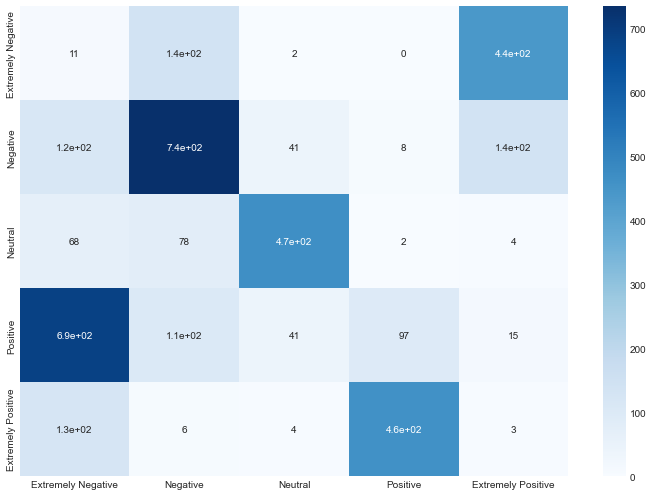

In [42]:
y_test = data_te['Sentiment'].tolist()
y_pred = prediction(model_bilstm, test_loader) 
eval_metrics(y_test, y_pred)

### 3. DistilBERT

In [49]:
data_tr = pd.read_csv('train_data.csv')
data_val = pd.read_csv('val_data.csv')
data_te = pd.read_csv('test_data.csv')

In [43]:
train_text = data_tr['CleanTweet'].values
train_labels = data_tr['Sentiment'].values

valid_text = data_val['CleanTweet'].values
valid_labels = data_val['Sentiment'].values

test_text = data_te['CleanTweet'].values
test_labels = data_te['Sentiment'].values

Apply the DistilBert tokenizer

In [44]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [45]:
train_encodings = tokenizer(list(train_text), truncation=True, padding=True)
valid_encodings = tokenizer(list(valid_text), truncation=True, padding=True)
test_encodings = tokenizer(list(test_text), truncation=True, padding=True)

Prepare the dataset and the dataloader

In [46]:
class tweetBERT_dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = tweetBERT_dataset(train_encodings, train_labels)
valid_dataset = tweetBERT_dataset(valid_encodings, valid_labels)
test_dataset = tweetBERT_dataset(test_encodings, test_labels)

In [48]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_BERT, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE_BERT, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_BERT, shuffle=False)

Training

In [52]:
model_distilBERT = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)
model_distilBERT.to(DEVICE)
model_distilBERT.train()

optim = torch.optim.Adam(model_distilBERT.parameters(), lr=5e-5)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

In [53]:
def get_accuracy2(model, data_loader, device):
    
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for batch_idx, batch in enumerate(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs['loss'], outputs['logits']
            _, predicted_labels = torch.max(logits, 1)
            
            num_examples += labels.size(0)
            correct_pred += (predicted_labels == labels).sum()
    
    return correct_pred.float() / num_examples * 100

In [54]:
start_time = time.time()

for epoch in range(NUM_EPOCHS_BERT):
    
    model_distilBERT.train()
    
    for batch_idx, batch in enumerate(train_loader):
        
        ### Prepare data
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)


        ### Forward
        outputs = model_distilBERT(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs['loss'], outputs['logits']
        
        ### Backward
        optim.zero_grad()
        loss.backward()
        optim.step()

        ### Logging
        if not batch_idx % 250:
            print (f'Epoch: {epoch+1:04d}/{NUM_EPOCHS_BERT:04d} | '
                   f'Batch {batch_idx:04d}/{len(train_loader):04d} | '
                   f'Loss: {loss:.4f}')
            
    model_distilBERT.eval()

    with torch.set_grad_enabled(False):
        print(f'training accuracy: '
              f'{get_accuracy2(model_distilBERT, train_loader, DEVICE):.2f}%'
              f'\nvalid accuracy: '
              f'{get_accuracy2(model_distilBERT, valid_loader, DEVICE):.2f}%')
        
    print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    
print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')
print(f'Test accuracy: {get_accuracy2(model_distilBERT, test_loader, DEVICE):.2f}%')

Epoch: 0001/0005 | Batch 0000/2314 | Loss: 1.6341
Epoch: 0001/0005 | Batch 0250/2314 | Loss: 0.7258
Epoch: 0001/0005 | Batch 0500/2314 | Loss: 0.6880
Epoch: 0001/0005 | Batch 0750/2314 | Loss: 0.6828
Epoch: 0001/0005 | Batch 1000/2314 | Loss: 0.7094
Epoch: 0001/0005 | Batch 1250/2314 | Loss: 0.5390
Epoch: 0001/0005 | Batch 1500/2314 | Loss: 0.9157
Epoch: 0001/0005 | Batch 1750/2314 | Loss: 0.4358
Epoch: 0001/0005 | Batch 2000/2314 | Loss: 0.1470
Epoch: 0001/0005 | Batch 2250/2314 | Loss: 0.5091
training accuracy: 84.13%
valid accuracy: 80.45%
Time elapsed: 10.82 min
Epoch: 0002/0005 | Batch 0000/2314 | Loss: 0.6047
Epoch: 0002/0005 | Batch 0250/2314 | Loss: 0.4185
Epoch: 0002/0005 | Batch 0500/2314 | Loss: 0.5216
Epoch: 0002/0005 | Batch 0750/2314 | Loss: 0.2476
Epoch: 0002/0005 | Batch 1000/2314 | Loss: 0.3781
Epoch: 0002/0005 | Batch 1250/2314 | Loss: 0.1805
Epoch: 0002/0005 | Batch 1500/2314 | Loss: 0.6171
Epoch: 0002/0005 | Batch 1750/2314 | Loss: 0.2857
Epoch: 0002/0005 | Batch 20

In [55]:
# Save and load the trained model
torch.save(model_distilBERT.state_dict(), 'saved_data/model_distilBERT.pt')
torch.save(optimizer.state_dict(), 'saved_data/optimizer_distilBERT.pt')

#model_distilBERT.load_state_dict(torch.load('saved_data/model_distilBERT.pt'))
#optimizer.load_state_dict(torch.load('saved_data/optimizer_distilBERT.pt'))

              precision    recall  f1-score   support

           0       0.75      0.92      0.83       480
           1       0.86      0.79      0.82      1136
           2       0.84      0.88      0.86       592
           3       0.85      0.79      0.82      1016
           4       0.84      0.88      0.86       572

    accuracy                           0.83      3796
   macro avg       0.83      0.85      0.84      3796
weighted avg       0.84      0.83      0.83      3796



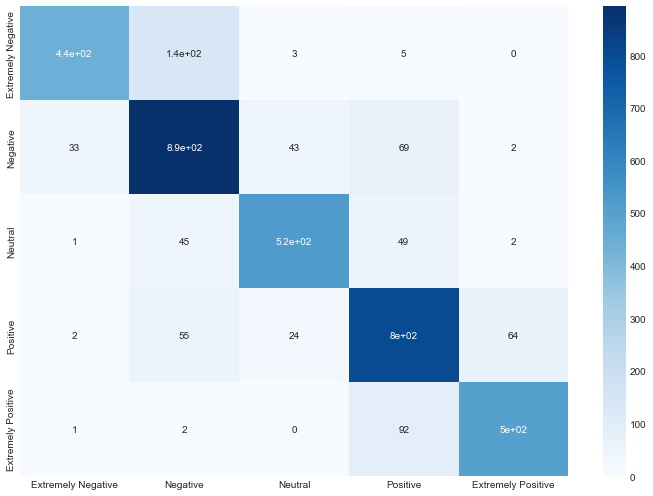

In [56]:
y_test = data_te['Sentiment'].tolist()

test_pred = []
with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        outputs = model_distilBERT(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs['loss'], outputs['logits']
        _, predicted_labels = torch.max(logits, 1)
        test_pred.extend(predicted_labels.cpu().detach().numpy().tolist())
y_pred = test_pred 

eval_metrics(y_test, y_pred)